  <h1 style="color: red;">Predicting fraudulent transactions</h1>

In [1]:
import pandas as pd
import scipy.stats as st
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

<h2> Load Dataset </h2>

In [2]:
df = pd.read_csv("Fraud.csv")

<h2>Understanding Data</h2>

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


<b>step</b> - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

<b>type</b> - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

<b>amount</b> - amount of the transaction in local currency.

<b>nameOrig</b> - customer who started the transaction

<b>oldbalanceOrg</b> - initial balance before the transaction

<b>newbalanceOrig</b> - new balance after the transaction

<b>nameDest</b> - customer who is the recipient of the transaction

<b>oldbalanceDest</b> - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

<b>newbalanceDest</b> - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

<b>isFraud</b> - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

<b>isFlaggedFraud</b> - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [5]:
df.shape

(6362620, 11)

In [6]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
df.drop_duplicates(inplace = True)

In [8]:
pd.set_option('display.float_format','{:.2f}'.format)
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00
mean,243.40,179861.90,833883.10,855113.67,1100701.67,1224996.40,0.00,0.00
std,142.33,603858.23,2888242.67,2924048.50,3399180.11,3674128.94,0.04,0.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,156.00,13389.57,0.00,0.00,0.00,0.00,0.00,0.00
50%,239.00,74871.94,14208.00,0.00,132705.66,214661.44,0.00,0.00
75%,335.00,208721.48,107315.18,144258.41,943036.71,1111909.25,0.00,0.00
max,743.00,92445516.64,59585040.37,49585040.37,356015889.35,356179278.92,1.00,1.00


In [9]:
df.describe(include = 'object')

,type,nameOrig,nameDest
count,6362620,6362620,6362620
unique,5,6353307,2722362
top,CASH_OUT,C1902386530,C1286084959
freq,2237500,3,113


<h2> Understanding Data </h2>

<h3> Univariate Analysis </h3> 

In [10]:
df['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

<Axes: xlabel='type', ylabel='count'>

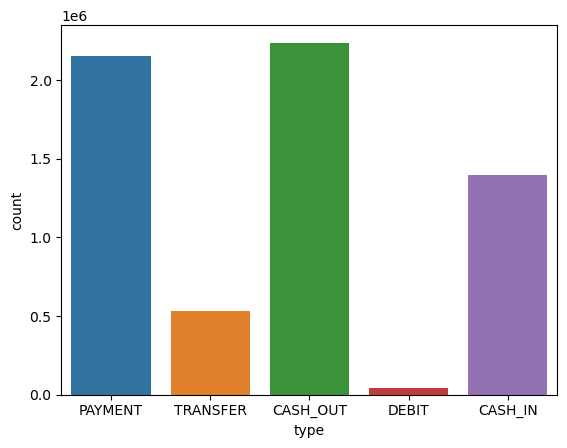

In [11]:
sns.countplot(x = df['type'], data = df)

In [12]:
print(df['nameOrig'].str.startswith('C').count())
print(df.shape)

6362620
(6362620, 11)


<b>The nameOrig column has no anomalies.</b>

In [13]:
normal_recipient = df['nameDest'].str.startswith('C') 
normal_recipient.sum()

4211125

In [14]:
merchant_recipient = df['nameDest'].str.startswith('M')
merchant_recipient.sum()

2151495

In [15]:
print(normal_recipient.sum() + merchant_recipient.sum())
print(df.shape)

6362620
(6362620, 11)


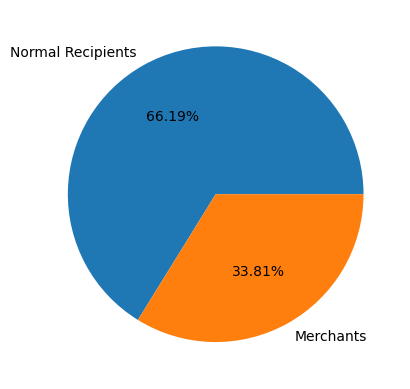

None


In [16]:
plt.pie(normal_recipient.value_counts(), labels = {"Normal Recipients": 1, "Merchants":0}.keys(),autopct='%.2f%%')
print(plt.show())

<b> The nameDest column has no anomalies. Transactions are made either to merchants or Normal recipients </b>

In [17]:
fraud_count = df['isFraud'].value_counts()
fraud_count

isFraud
0    6354407
1       8213
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x2900806ee10>,
 [Text(-1.099990955625572, 0.004460666087110192, 'Safe transaction'),
  Text(1.0999909559371663, -0.004460589247970448, 'Fraud Transaction')],
 [Text(-0.5999950667048575, 0.002433090592969195, '99.87%'),
  Text(0.599995066874818, -0.002433048680711153, '0.13%')])

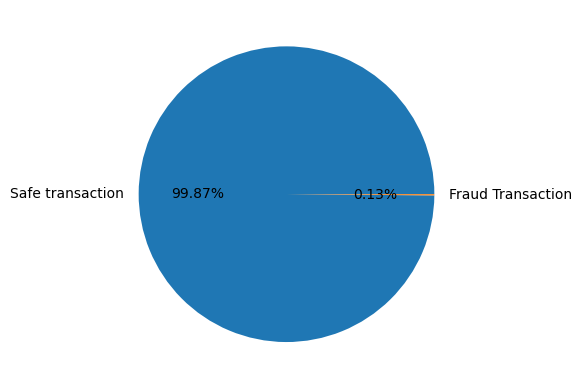

In [18]:
plt.pie(fraud_count, labels = {"Safe transaction":0, "Fraud Transaction":1}.keys(), autopct = '%1.2f%%')

<h3> Bi-Variate Analysis </h3>

In [19]:
numeric_df = df.select_dtypes(include=[np.number])
numeric_df.corr()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.00,0.02,-0.01,-0.01,0.03,0.03,0.03,0.00
amount,0.02,1.00,-0.00,-0.01,0.29,0.46,0.08,0.01
oldbalanceOrg,-0.01,-0.00,1.00,1.00,0.07,0.04,0.01,0.00
newbalanceOrig,-0.01,-0.01,1.00,1.00,0.07,0.04,-0.01,0.00
oldbalanceDest,0.03,0.29,0.07,0.07,1.00,0.98,-0.01,-0.00
newbalanceDest,0.03,0.46,0.04,0.04,0.98,1.00,0.00,-0.00
isFraud,0.03,0.08,0.01,-0.01,-0.01,0.00,1.00,0.04
isFlaggedFraud,0.00,0.01,0.00,0.00,-0.00,-0.00,0.04,1.00


<Axes: >

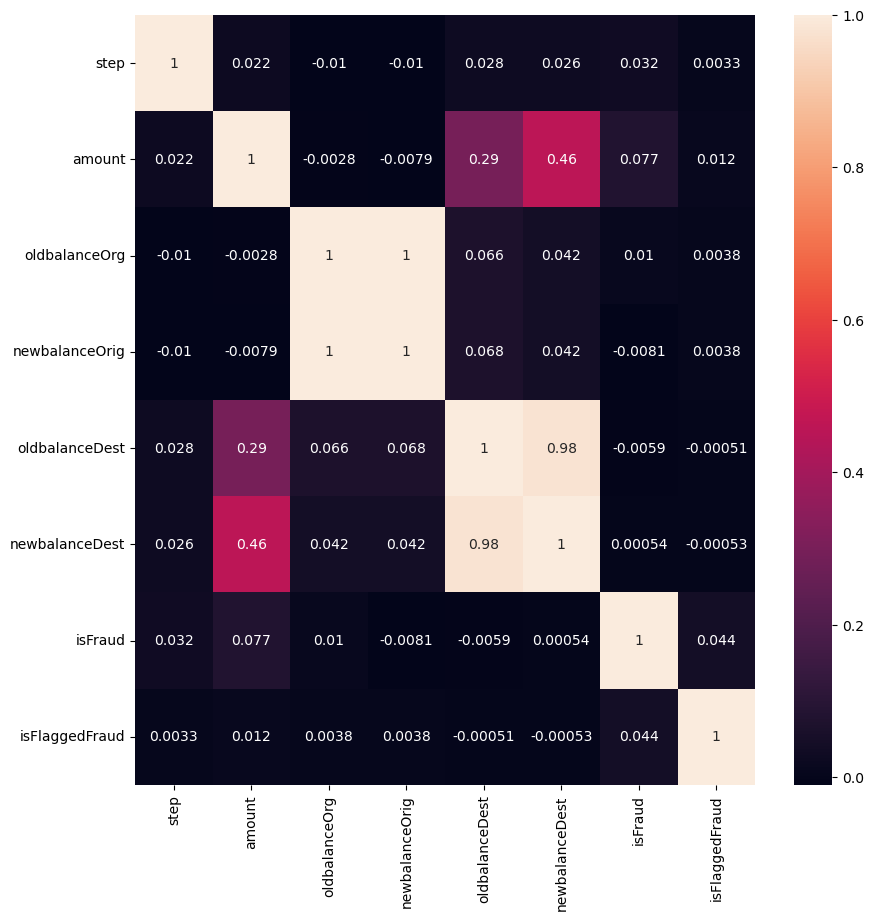

In [20]:
plt.figure(figsize=(10,10))
sns.heatmap(numeric_df.corr(),annot = True)

<b style="color: orange;">Order of correlated metrics:</b><br>
<b style="color: orange;">newbalanceOrig < oldbalanceDest < oldbalanceOrg < newbalanceDest < step < isFlaggedFraud < amount</b>

<h3> Converting categorical variables into Numeric type </h3>

In [21]:
le_type = LabelEncoder()
le_orig = LabelEncoder()
le_dest = LabelEncoder()

# Fit and transform the 'type' column
df['type'] = le_type.fit_transform(df['type'])

# Fit and transform the 'nameOrig' column
df['nameOrig'] = le_orig.fit_transform(df['nameOrig'])

# Fit and transform the 'nameDest' column
df['nameDest'] = le_dest.fit_transform(df['nameDest'])

In [22]:
le_type.classes_

array(['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER'],
      dtype=object)

In [23]:
le_orig.classes_

array(['C1000000639', 'C1000001337', 'C1000001725', ..., 'C999999254',
       'C999999614', 'C999999784'], dtype=object)

In [24]:
le_dest.classes_

array(['C1000004082', 'C1000004940', 'C1000013769', ..., 'M999999089',
       'M999999543', 'M999999784'], dtype=object)

In [25]:
df.sample(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
829808,41,3,2147.53,3018933,0.00,0.00,1585866,0.00,0.00,0,0
2159409,184,4,435477.00,4351162,222.00,0.00,70941,0.00,435477.00,0,0
4439210,323,3,52105.48,6083934,11042.00,0.00,1173520,0.00,0.00,0,0
1507122,144,1,331003.56,1837806,0.00,0.00,382768,393796.84,724800.39,0,0
3824594,282,3,7459.12,5836996,0.00,0.00,1310987,0.00,0.00,0,0
4577008,328,3,36095.38,2407134,121545.00,85449.62,1752177,0.00,0.00,0,0
1701482,159,1,4702.57,202414,0.00,0.00,187354,233013.01,237715.58,0,0
3431894,256,0,268074.48,652938,103799.00,371873.48,514582,0.00,0.00,0,0
5430857,378,4,838775.40,2648373,0.00,0.00,457888,3054583.29,3893358.68,0,0
5140327,356,0,86711.26,663603,21467.00,108178.26,45036,984729.89,898018.63,0,0


<h2> Splitting data into X and Y </h2>
<h4 style = "color:green;">We are considering all the metrics.</h4>

In [26]:
x = df.drop(columns=['isFraud'])
y = df['isFraud']

<h2> Scaling data </h2>

In [27]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

<br>
<br>
<h1 style="color:red;">Method 1 - Logistic Regression - Holdout Technique </h1>
<h3 style="color:green;">Holdout Technique: Traning data - 80% , Testing Data - 20% </h3>
--------------------------------------------------------------------------------------------------------------

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.20,random_state=0)

<h4>Apply Logistic Regression</h4>

In [29]:
log_reg = LogisticRegression()
log_reg.fit(x_train,y_train)
y_pred_log_reg = log_reg.predict(x_test)

<h4>Check Performance of the model</h4>

In [30]:
print(confusion_matrix(y_test,y_pred_log_reg))
print(accuracy_score(y_test,y_pred_log_reg))
print(print(classification_report(y_test,y_pred_log_reg)))

[[1270882       1]
 [   1491     150]]
0.9988275270250305
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270883
           1       0.99      0.09      0.17      1641

    accuracy                           1.00   1272524
   macro avg       1.00      0.55      0.58   1272524
weighted avg       1.00      1.00      1.00   1272524

None


<h3 style="color:green;">Holdout Technique: Traning data - 70% , Testing Data - 30% </h3>
----------------------------------------------------------------------------------------------------------------

<h4> Applying Logistic Regression </h4>

In [31]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x,y,test_size=0.30,random_state=0)
log_reg2 = LogisticRegression()
log_reg2.fit(x_train2,y_train2)
y_pred2_log_reg = log_reg2.predict(x_test2)

<h4>Check Performance of the model</h4>

In [32]:
print(confusion_matrix(y_test2,y_pred2_log_reg))
print(accuracy_score(y_test2,y_pred2_log_reg))
print(classification_report(y_test2,y_pred2_log_reg))

[[1906364       3]
 [   2217     202]]
0.9988369571025772
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906367
           1       0.99      0.08      0.15      2419

    accuracy                           1.00   1908786
   macro avg       0.99      0.54      0.58   1908786
weighted avg       1.00      1.00      1.00   1908786



<h3 style="color:green;">Holdout Technique: Traning data - 60% , Testing Data - 40% </h3>
----------------------------------------------------------------------------------------------------------------

<h4> Applying Logistic Regression </h4>

In [33]:
x_train3, x_test3, y_train3, y_test3 = train_test_split(x,y,test_size=0.40,random_state=0)
log_reg3 = LogisticRegression()
log_reg3.fit(x_train3,y_train3)
y_pred3_log_reg = log_reg3.predict(x_test3)

<h4>Check Performance of the model</h4>

In [34]:
print(confusion_matrix(y_test3,y_pred3_log_reg))
print(accuracy_score(y_test3,y_pred3_log_reg))
print(classification_report(y_test3,y_pred3_log_reg))

[[2541798       3]
 [   3011     236]]
0.9988157394280972
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2541801
           1       0.99      0.07      0.14      3247

    accuracy                           1.00   2545048
   macro avg       0.99      0.54      0.57   2545048
weighted avg       1.00      1.00      1.00   2545048



<br>
<br>
<h1 style="color:red;">Method 2 - Logistic Regression - Cross Validation Technique</h1>

<h5 style="color:green;">3-Fold</h5>

In [35]:
cvs_3 = cross_val_score(log_reg,x,y,cv=3)
print(cvs_3)
print(cvs_3.mean())

[0.99873213 0.99880379 0.99786267]
0.9984661978452385


<h5 style="color:green;">4-Fold</h5>

In [36]:
cvs_4 = cross_val_score(log_reg,x,y,cv=4)
print(cvs_4)
print(cvs_4.mean())

[0.9987414  0.99879421 0.99879987 0.99782165]
0.9985392809880206


<h5 style="color:green;">5-Fold</h5>

In [37]:
cvs_5 = cross_val_score(log_reg,x,y,cv=5)
print(cvs_5)
print(cvs_5.mean())

[0.99874344 0.99878352 0.9988291  0.99880317 0.99819178]
0.9986702018979603


<h5 style="color:green;">10-Fold</h5>

In [38]:
cvs_10 = cross_val_score(log_reg,x,y,cv=10)
print(cvs_10)
print(cvs_10.mean())

[0.99874108 0.9987788  0.99878981 0.99879924 0.9988291  0.99884482
 0.99884796 0.99878981 0.99884953 0.99898784]
0.9988257981774803


<h1 style="color:red;">Method 3 - Decision Tree - Holdout Technique</h1>

<h3 style="color:green;">Holdout Technique: Traning data - 80% , Testing Data - 20% </h3>
--------------------------------------------------------------------------------------------------------------

<h4> Applying Decision Tree </h4>

In [39]:
dec_tree = DecisionTreeClassifier()
dec_tree.fit(x_train, y_train)

# Predictions using Decision Tree
y_pred_dec_tree = dec_tree.predict(x_test)


<h4> Check performance of the model </h4>

In [40]:
print("\nDecision Tree Performance:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dec_tree))
print("Accuracy Score:", accuracy_score(y_test, y_pred_dec_tree))
print("Classification Report:\n", classification_report(y_test, y_pred_dec_tree))


Decision Tree Performance:
Confusion Matrix:
 [[1270669     214]
 [    221    1420]]
Accuracy Score: 0.9996581596889331
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270883
           1       0.87      0.87      0.87      1641

    accuracy                           1.00   1272524
   macro avg       0.93      0.93      0.93   1272524
weighted avg       1.00      1.00      1.00   1272524



<h3 style="color:green;">Holdout Technique: Traning data - 70% , Testing Data - 30% </h3>
--------------------------------------------------------------------------------------------------------------

<h4> Applying Decision Tree </h4>

In [41]:
dec_tree2 = DecisionTreeClassifier()
dec_tree2.fit(x_train2, y_train2)

y_pred2_dec_tree = dec_tree2.predict(x_test2)

<h4> Check performance of the model </h4>

In [42]:
print("\nDecision Tree Performance:")
print("Confusion Matrix:\n", confusion_matrix(y_test2, y_pred2_dec_tree))
print("Accuracy Score:", accuracy_score(y_test2, y_pred2_dec_tree))
print("Classification Report:\n", classification_report(y_test2, y_pred2_dec_tree))


Decision Tree Performance:
Confusion Matrix:
 [[1906031     336]
 [    330    2089]]
Accuracy Score: 0.9996510871307732
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906367
           1       0.86      0.86      0.86      2419

    accuracy                           1.00   1908786
   macro avg       0.93      0.93      0.93   1908786
weighted avg       1.00      1.00      1.00   1908786



<h3 style="color:green;">Holdout Technique: Traning data - 60% , Testing Data - 40% </h3>
--------------------------------------------------------------------------------------------------------------

<h4> Applying Decision Tree </h4>

In [43]:
dec_tree3 = DecisionTreeClassifier()
dec_tree3.fit(x_train3, y_train3)

y_pred3_dec_tree = dec_tree3.predict(x_test3)

<h4> Check performance of the model </h4>

In [44]:
print("\nDecision Tree Performance:")
print("Confusion Matrix:\n", confusion_matrix(y_test3, y_pred3_dec_tree))
print("Accuracy Score:", accuracy_score(y_test3, y_pred3_dec_tree))
print("Classification Report:\n", classification_report(y_test3, y_pred3_dec_tree))


Decision Tree Performance:
Confusion Matrix:
 [[2541315     486]
 [    458    2789]]
Accuracy Score: 0.9996290836164976
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   2541801
           1       0.85      0.86      0.86      3247

    accuracy                           1.00   2545048
   macro avg       0.93      0.93      0.93   2545048
weighted avg       1.00      1.00      1.00   2545048



<h1>Fraud Detection With Selected Metrics </h1>

<b style="color: orange;">Order of correlated metrics:</b><br>
<b style="color: orange;">newbalanceOrig < oldbalanceDest < oldbalanceOrg < newbalanceDest < step < isFlaggedFraud < amount</b>

<h2> Splitting data into X and Y </h2>
<h4 style = "color:green;">We are Removing Least Correlated metric</h4>

In [45]:
x = df.drop(columns=['isFraud', 'newbalanceOrig'])
y = df['isFraud']

In [46]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

In [47]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.20,random_state=0)

In [48]:
log_reg = LogisticRegression()
log_reg.fit(x_train,y_train)
y_pred_log_reg = log_reg.predict(x_test)

In [49]:
print(confusion_matrix(y_test,y_pred_log_reg))
print(accuracy_score(y_test,y_pred_log_reg))
print(print(classification_report(y_test,y_pred_log_reg)))

[[1270879       4]
 [   1617      24]]
0.9987261536914038
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270883
           1       0.86      0.01      0.03      1641

    accuracy                           1.00   1272524
   macro avg       0.93      0.51      0.51   1272524
weighted avg       1.00      1.00      1.00   1272524

None


 <h3 style="color: red;">It is better if we consider all the metrics because , if we are removing the leastly correlated metric the accuracy of the model is decreasing and false negative cases are increasing.
    
so for better accuracy and decreasing the false negatives cases we should consider all the metrics</h3>

<h1>----------------------------------------------------------------------------------------------------------</h1>

# Fraud Detection Models Comparison

## Method 1: Logistic Regression - Holdout Technique

### 80% Training, 20% Testing
| Metric                    | Value  |
|---------------------------|--------|
| Accuracy                  | 0.9988 |
| Recall for fraud (class 1)| 0.09   |

### 70% Training, 30% Testing
| Metric                    | Value  |
|---------------------------|--------|
| Accuracy                  | 0.9988 |
| Recall for fraud (class 1)| 0.08   |

### 60% Training, 40% Testing
| Metric                    | Value  |
|---------------------------|--------|
| Accuracy                  | 0.9988 |
| Recall for fraud (class 1)| 0.07   |

## Method 2: Logistic Regression - Cross Validation Technique

### 3-Fold Cross-Validation
| Fold  | Accuracy    |
|-------|-------------|
| Fold 1| 0.99873213  |
| Fold 2| 0.99880379  |
| Fold 3| 0.99786267  |
| **Mean Accuracy** | **0.9984661978452385** |

### 4-Fold Cross-Validation
| Fold  | Accuracy    |
|-------|-------------|
| Fold 1| 0.9987414   |
| Fold 2| 0.99879421  |
| Fold 3| 0.99879987  |
| Fold 4| 0.99782165  |
| **Mean Accuracy** | **0.9985392809880206** |

### 5-Fold Cross-Validation
| Fold  | Accuracy    |
|-------|-------------|
| Fold 1| 0.99874344  |
| Fold 2| 0.99878352  |
| Fold 3| 0.9988291   |
| Fold 4| 0.99880317  |
| Fold 5| 0.99819178  |
| **Mean Accuracy** | **0.9986702018979603** |

### 10-Fold Cross-Validation
| Fold  | Accuracy    |
|-------|-------------|
| Fold 1| 0.99874108  |
| Fold 2| 0.9987788   |
| Fold 3| 0.99878981  |
| Fold 4| 0.99879924  |
| Fold 5| 0.9988291   |
| Fold 6| 0.99884482  |
| Fold 7| 0.99884796  |
| Fold 8| 0.99878981  |
| Fold 9| 0.99884953  |
| Fold 10| 0.99898784 |
| **Mean Accuracy** | **0.9988257981774803** |

## Method 3: Decision Tree - Holdout Technique

### 80% Training, 20% Testing
| Metric                    | Value  |
|---------------------------|--------|
| Accuracy                  | 0.9997 |
| Recall for fraud (class 1)| 0.86   |

### 70% Training, 30% Testing
| Metric                    | Value  |
|---------------------------|--------|
| Accuracy                  | 0.9996 |
| Recall for fraud (class 1)| 0.86   |

### 60% Training, 40% Testing
| Metric                    | Value  |
|---------------------------|--------|
| Accuracy                  | 0.9996 |
| Recall for fraud (class 1)| 0.86   |



<h1> ---------------------------------------------------------------------------------------------------------- </h1>
<h1 style="color: red;">Analysis and Conclusion</h1>

## Accuracy
Both models are very accurate. The Decision Tree model is a bit better than the Logistic Regression model when using the holdout technique.

## Recall for Fraud Detection

- **Logistic Regression**: The ability to find fraud is very low (around 0.07 to 0.09), meaning it misses many fraudulent transactions.
- **Decision Tree**: The ability to find fraud is much higher (around 0.86), meaning it finds most fraudulent transactions.

## Cross-Validation vs. Holdout

- **Cross-Validation**: Gives a more reliable measure of model performance by averaging results over multiple tests. The average accuracy for Logistic Regression is a bit lower than the holdout technique but more reliable.
- **Holdout Technique**: Shows slightly higher accuracy for Logistic Regression but with much lower ability to find fraud.

## Recommendation
Because finding fraud is very important (we want to miss as few fraudulent transactions as possible), the Decision Tree model using the holdout technique is the better choice. This model not only has the highest accuracy but also a much better ability to find fraud compared to Logistic Regression.

The Decision Tree's ability to find fraud stays consistent across different training/test splits, showing it is reliable in finding fraudulent transactions. This balance between accuracy and the ability to find fraud makes it a better model for fraud detection in this case.